The purposes of this notebook are:

* Analyze data from california housing dataset with plots and on interactives Leaflet.js maps using Folium.
* Employment of Auto machine learning tool TPOT to optimize the regressor used to predict house prices. In this case the resulting pipeline of TPOT proposes a XGBoost Regressor which is implemented later.

It is possible to interact with the maps of this jupyter notebook using nbviewer in the following link:

http://nbviewer.jupyter.org/github/alvertogit/datascience/blob/master/Geospatial%20analysis%20TPOT%20XGBoost%20california%20housing.ipynb


**Data Set Characteristics:**

Number of Instances: 20640

Number of Attributes: 8 numeric, predictive attributes and the target

Attribute Information:
- MedInc        median income in block
- HouseAge      median house age in block
- AveRooms      average number of rooms
- AveBedrms     average number of bedrooms
- Population    block population
- AveOccup      average house occupancy
- Latitude      house block latitude
- Longitude     house block longitude

Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
http://lib.stat.cmu.edu/datasets/
The target variable is the median house value for California districts.

This dataset was derived from the 1990 U.S. census, using one row per census block group. A block group is the smallest geographical unit for which the U.S.

Census Bureau publishes sample data (a block group typically has a population\nof 600 to 3,000 people).

References
- Pace, R. Kelley and Ronald Barry, Sparse Spatial Autoregressions,Statistics and Probability Letters, 33 (1997) 291-297

In [ ]:
import folium  # interactive map
import matplotlib.pyplot as plt  # plotting
import numpy as np  # linear algebra, arrays
import pandas as pd  # data structures
import pickle
import seaborn as sns  # statistical data visualization
import xgboost as xgb  # extreme gradient boosting
from sklearn import metrics
from sklearn.datasets import fetch_california_housing  # california housing dataset
from tpot import TPOTRegressor

/.venv/lib/python3.12/site-packages/stopit/__init__.py:10: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [2]:
dataset = fetch_california_housing()

In [3]:
feature_names = dataset.feature_names
print(feature_names)

['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']


Split data into training (75%) and testing (25%)

In [4]:
from sklearn.model_selection import train_test_split

train_features, test_features, train_labels, test_labels = train_test_split(
    dataset.data, dataset.target, test_size=0.25, random_state=4
)

**Data analysis**

In [5]:
print(train_features.shape)
print(train_labels.shape)

(15480, 8)
(15480,)


In [6]:
print(f"Train labels range: {min(train_labels)} - {max(train_labels)}")

Train labels range: 0.14999 - 5.00001


In [7]:
print(test_features.shape)
print(test_labels.shape)

(5160, 8)
(5160,)


House distribution based on location

<Figure size 1000x1000 with 0 Axes>

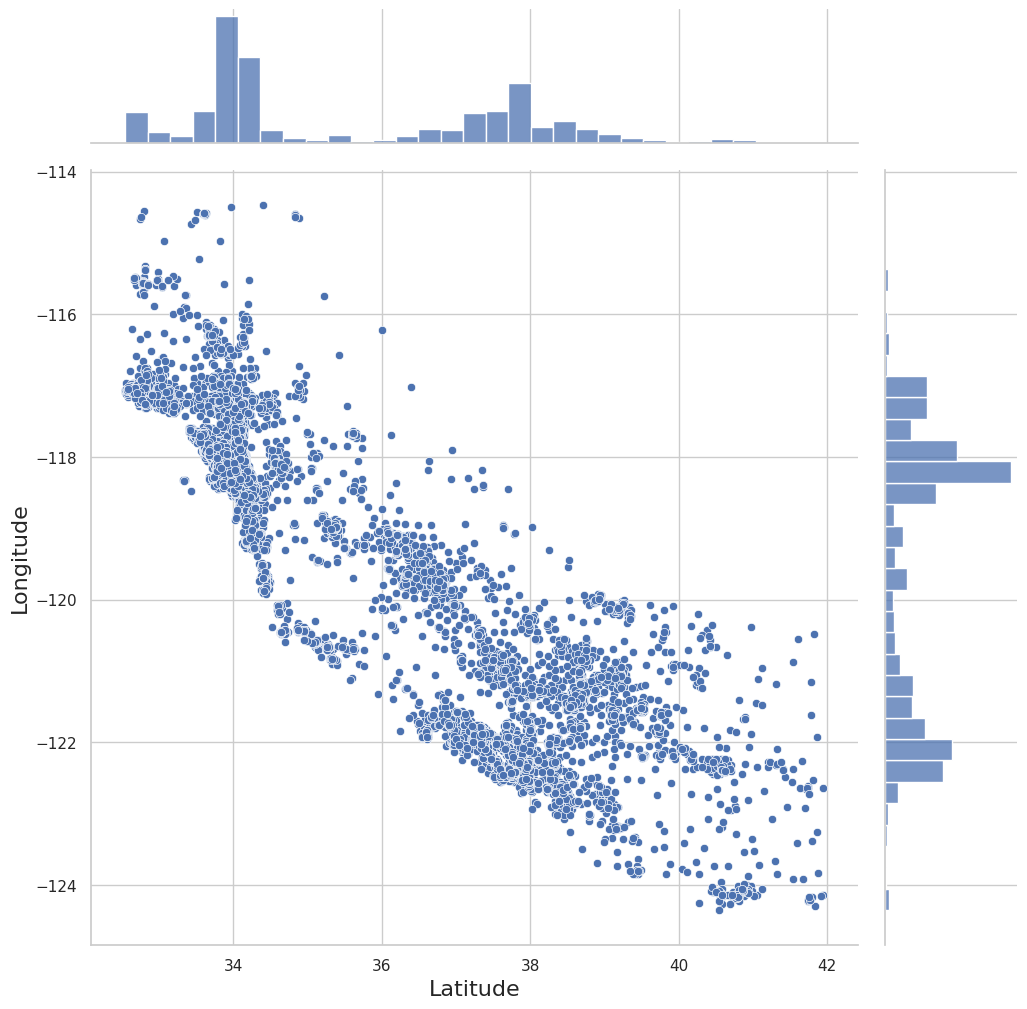

In [8]:
sns.set(style="whitegrid")
plt.figure(figsize=(10, 10))
sns.jointplot(x=train_features[:, 6], y=train_features[:, 7], height=10)
plt.ylabel("Longitude", fontsize=16)
plt.xlabel("Latitude", fontsize=16)
plt.show()

Interactive heatmap with folium needs some data preparation

In [9]:
heat_data = [[train_features[i][6], train_features[i][7]] for i in range(len(train_features))]

California housing interactive heatmap based on location

In [10]:
from folium.plugins import HeatMap

california_heat_map = folium.Map([37, -120], tiles="OpenStreetMap", zoom_start=6)

HeatMap(heat_data, radius=14).add_to(california_heat_map)

california_heat_map

Housing analysis based on location, price and population (circles radius)

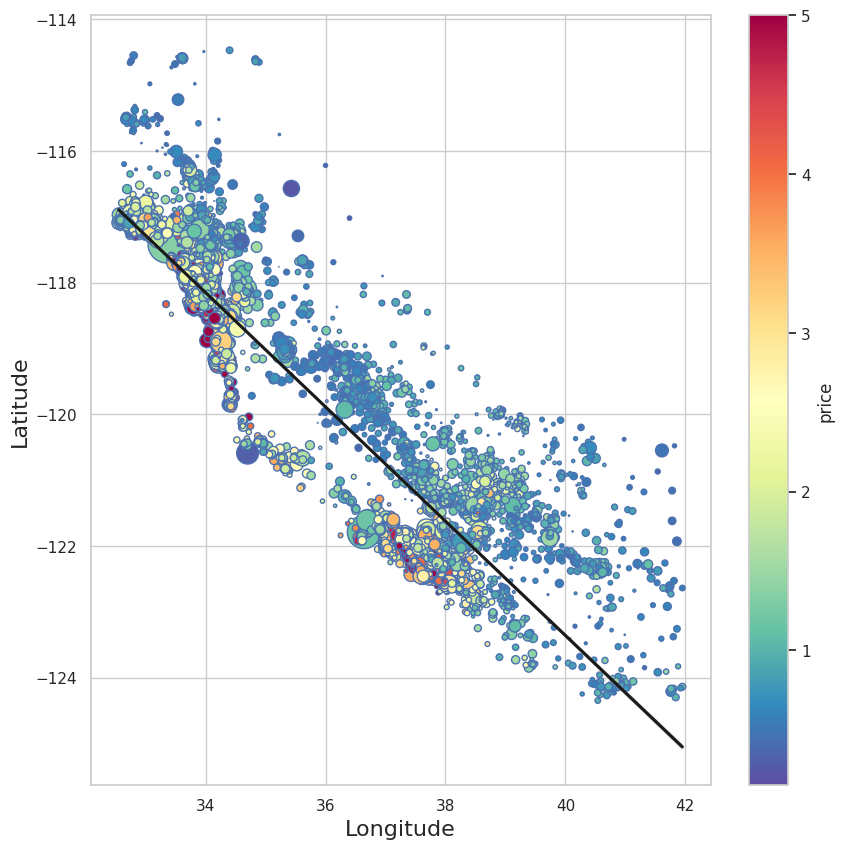

In [11]:
plt.figure(figsize=(10, 10))
points = plt.scatter(
    x=train_features[:, 6],
    y=train_features[:, 7],
    s=train_features[:, 4] / 50,
    c=train_labels,
    cmap="Spectral_r",
    edgecolors="b",
)  # set style options

plt.colorbar(points, label="price")  # add a color bar
sns.regplot(x=train_features[:, 6], y=train_features[:, 7], scatter=False, color=".1")
plt.ylabel("Latitude", fontsize=16)
plt.xlabel("Longitude", fontsize=16)
plt.show()

Interactive housing map for 1000 train samples using circles

Color circles go from blue (lower prices) to red (higher prices)

In [12]:
train_labels_color = pd.cut(
    train_labels, bins=5, labels=["blue", "green", "yellow", "orange", "red"]
)

Circles properties provide additional information for price (color) and population (radius)

In [13]:
california_prices_map = folium.Map([36, -120], tiles="Cartodb Positron", zoom_start=7)

# create feature group
fg = folium.FeatureGroup(name="housing locations")

# drawing 1000 samples
for i in range(1000):
    my_Circle = folium.CircleMarker(
        location=[train_features[i][6], train_features[i][7]],
        radius=train_features[i][4] / 400,
        fill=True,
        color=train_labels_color[i],
        fill_opacity=0.7,
    )
    fg.add_child(my_Circle)

california_prices_map.add_child(fg)

Population and coast proximity affect prices

Employ TPOT for Auto machine learning to optimize pipeline using genetic programming

In [14]:
tpot = TPOTRegressor(
    search_space="linear",
    generations=5,
    population_size=50,
    max_time_mins=5,
    max_eval_time_mins=2,
    verbose=2,
    n_jobs=2,
)  # 2 CPU cores, -1 all cores
tpot.fit(train_features, train_labels)

/.venv/lib/python3.12/site-packages/tpot/tpot_estimator/estimator.py:458: UserWarning: Both generations and max_time_mins are set. TPOT will terminate when the first condition is met.
  warnings.warn("Both generations and max_time_mins are set. TPOT will terminate when the first condition is met.")
Generation:   0%|                                         | 0/5 [00:00<?, ?it/s]/.venv/lib/python3.12/site-packages/stopit/__init__.py:10: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
/.venv/lib/python3.12/site-packages/stopit/__init__.py:10: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools

TPOTRegressor(max_eval_time_mins=2, max_time_mins=5, n_jobs=2,
              search_space=<tpot.search_spaces.pipelines.sequential.SequentialPipeline object at 0x7b4fe19c8ec0>)

Calculate pipeline score

In [15]:
print(tpot.scorers)

['neg_mean_squared_error']


In [16]:
scorer = metrics.get_scorer('neg_mean_squared_error')
print(scorer(tpot, test_features, test_labels))

-0.23222240431528585


/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


It is negative because for regression scoring tpot uses 'neg_mean_squared_error'

Tpot pipeline

In [17]:
tpot.fitted_pipeline_

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('variancethreshold',
                 VarianceThreshold(threshold=0.0134252969319)),
                ('featureunion-1',
                 FeatureUnion(transformer_list=[('skiptransformer',
                                                 SkipTransformer()),
                                                ('passthrough',
                                                 Passthrough())])),
                ('featureunion-2',
                 FeatureUnion(transformer_list=[('featureunion',
                                                 FeatureUnion(transformer_list=[('estimatortran...
                                                                                                                             epsilon=0.0177166230929,
                                                                                                                             eta0=0.002980450998,
                                                                                                                             fit_intercept=np.True_,
                                                                                                                             l1_ratio=0.0013080203854,
                                                                                                                             learning_rate=np.str_('invscaling'),
                                                                                                                             loss=np.str_('huber'),
                                                                                                                             penalty=np.str_('elasticnet'),
                                                                                                                             power_t=0.0237247990346)))])),
                                                ('passthrough',
                                                 Passthrough())])),
                ('lgbmregressor',
                 LGBMRegressor(boosting_type=np.str_('gbdt'), max_depth=7,
                               n_estimators=78, n_jobs=1, num_leaves=115,
                               verbose=-1))])

Export tpot pipeline to a file

In [18]:
pickle.dump(tpot.fitted_pipeline_, open('tpot_model.pkl','wb'))

In [19]:
model = pickle.load(open('tpot_model.pkl','rb'))

Wrap train and test features into dataframes to have available feature column names

In [20]:
train_features_df = pd.DataFrame(train_features, columns=feature_names)
test_features_df = pd.DataFrame(test_features, columns=feature_names)

Fit model

In [21]:
model.fit(train_features_df, train_labels)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('variancethreshold',
                 VarianceThreshold(threshold=0.0134252969319)),
                ('featureunion-1',
                 FeatureUnion(transformer_list=[('skiptransformer',
                                                 SkipTransformer()),
                                                ('passthrough',
                                                 Passthrough())])),
                ('featureunion-2',
                 FeatureUnion(transformer_list=[('featureunion',
                                                 FeatureUnion(transformer_list=[('estimatortran...
                                                                                                                             epsilon=0.0177166230929,
                                                                                                                             eta0=0.002980450998,
                                                                                                                             fit_intercept=np.True_,
                                                                                                                             l1_ratio=0.0013080203854,
                                                                                                                             learning_rate=np.str_('invscaling'),
                                                                                                                             loss=np.str_('huber'),
                                                                                                                             penalty=np.str_('elasticnet'),
                                                                                                                             power_t=0.0237247990346)))])),
                                                ('passthrough',
                                                 Passthrough())])),
                ('lgbmregressor',
                 LGBMRegressor(boosting_type=np.str_('gbdt'), max_depth=7,
                               n_estimators=78, n_jobs=1, num_leaves=115,
                               verbose=-1))])

Get predictions for test dataset

In [22]:
predictions = model.predict(test_features_df)

/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


In [23]:
predictions[:10]

array([1.57166943, 2.80541557, 1.29432523, 1.19961196, 3.62113275,
       0.86200977, 2.62290469, 4.32833352, 1.31884425, 1.18025221])

In [24]:
test_labels[:10]

array([1.752  , 3.147  , 0.9    , 1.231  , 3.509  , 0.873  , 2.127  ,
       5.00001, 1.375  , 1.107  ])

Calculate model mean squared error for test dataset

In [25]:
np.sqrt(metrics.mean_squared_error(predictions, test_labels))

np.float64(0.479747911583477)